In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from tqdm.notebook import trange, tqdm
import random

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.distributions import Categorical

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision

In [2]:
from transformers import AutoTokenizer
os.environ["TOKENIZERS_PARALLELISM"] = "false"

torch.backends.cuda.matmul.allow_tf32 = True

In [3]:
# Define the learning rate for the optimizer
learning_rate = 1e-4

# Image size
image_size = 128

# Define the number of epochs for training
nepochs = 200

# Define the batch size for mini-batch gradient descent
batch_size = 128

# Define the root directory of the dataset
data_set_root='./dataset'
train_set ='train2014'
validation_set ='val2014'

train_image_path = os.path.join(data_set_root, train_set)
train_ann_file = '{}/annotations/captions_{}.json'.format(data_set_root, train_set)

val_image_path = os.path.join(data_set_root, validation_set)
val_ann_file = '{}/annotations/captions_{}.json'.format(data_set_root, validation_set)

In [4]:
# Simple transform class to randomly sample one of the five captions
class SampleCaption(nn.Module):
    def __call__(self, sample):
        rand_index = random.randint(0, len(sample) - 1)
        return sample[rand_index]

In [5]:
train_transform = transforms.Compose([transforms.Resize(image_size),
                                      transforms.RandomCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225]),
                                      transforms.RandomErasing(p=0.5)]) 

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])]) 

train_dataset = datasets.CocoCaptions(root=train_image_path,
                                      annFile=train_ann_file,
                                      transform=train_transform,                                      
                                      target_transform=SampleCaption())

val_dataset = datasets.CocoCaptions(root=val_image_path,
                                    annFile=val_ann_file,
                                    transform=transform,
                                    target_transform=SampleCaption())

data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
data_loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

loading annotations into memory...
Done (t=1.52s)
creating index...
index created!
loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


In [6]:
dataiter = next(iter(data_loader_val))
# Sample from the itterable object
test_images, test_captions = dataiter

In [7]:
test_images.shape, len(test_captions)

(torch.Size([128, 3, 128, 128]), 128)

A man getting ready to throw a Frisbee on a field.


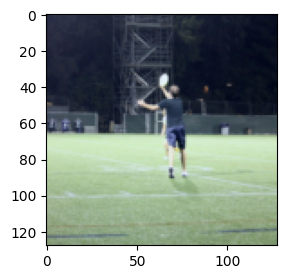

In [8]:
plt.figure(figsize = (3,3))
out = torchvision.utils.make_grid(test_images[0:1], 1, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

caption = test_captions[0]
print(caption)

In [9]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [10]:
tokenizer.vocab_size

30522

In [11]:
tokens = tokenizer(test_captions, padding=True, truncation=True, return_tensors="pt")

In [12]:
tokens.keys()

dict_keys(['input_ids', 'attention_mask'])

In [13]:
print(tokens['attention_mask'])
print(tokens.attention_mask.shape)

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
torch.Size([128, 25])


In [14]:
token_ids = tokens['input_ids'][0]

In [15]:
print(tokenizer.decode(token_ids, skip_special_tokens=True))

a man getting ready to throw a frisbee on a field.


In [16]:
## Model

In [17]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-specical token.
    
    Args:
        prob (float): probability of dropping a token
        blank_token (int): index for the blank token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, blank_token=1, eos_token=102):
        self.prob = prob
        self.eos_token = eos_token
        self.blank_token = blank_token

    def __call__(self, sample):
        # Randomly sample a bernoulli distribution with p=prob
        # to create a mask where 1 means we will replace that token
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        # only replace if the token is not the eos token
        can_drop = (~(sample == self.eos_token)).long()
        mask = mask * can_drop
        
        # Do not replace the sos tokens
        mask[:, 0] = torch.zeros_like(mask[:, 0]).long()
        
        replace_with = (self.blank_token * torch.ones_like(sample)).long()
        
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

In [18]:
def extract_patches(image_tensor, patch_size=16):
    # Get the dimensions of the image tensor
    bs, c, h, w = image_tensor.size()
    
    # Define the Unfold layer with appropriate parameters
    unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)
    
    # Apply Unfold to the image tensor
    unfolded = unfold(image_tensor)
    
    # Reshape the unfolded tensor to match the desired output shape
    # Output shape: BSxLxH, where L is the number of patches in each dimension
    unfolded = unfolded.transpose(1, 2).reshape(bs, -1, c * patch_size * patch_size)
    
    return unfolded

# sinusoidal positional embeds
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb
    

# Define a module for attention blocks
class AttentionBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, masking=True):
        super(AttentionBlock, self).__init__()
        self.masking = masking

        # Multi-head attention mechanism
        self.multihead_attn = nn.MultiheadAttention(hidden_size,
                                                    num_heads=num_heads,
                                                    batch_first=True,
                                                    dropout=0.0)

    def forward(self, x_in, kv_in, key_mask=None):
        # Apply causal masking if enabled
        if self.masking:
            bs, l, h = x_in.shape
            mask = torch.triu(torch.ones(l, l, device=x_in.device), 1).bool()
        else:
            mask = None
            
        # Perform multi-head attention operation
        return self.multihead_attn(x_in, kv_in, kv_in, attn_mask=mask, 
                                   key_padding_mask=key_mask)[0]


# Define a module for a transformer block with self-attention 
# and optional causal masking
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, decoder=False, masking=True):
        super(TransformerBlock, self).__init__()
        self.decoder = decoder

        # Layer normalization for the input
        self.norm1 = nn.LayerNorm(hidden_size)
        # Self-attention mechanism
        self.attn1 = AttentionBlock(hidden_size=hidden_size, num_heads=num_heads, 
                                    masking=masking)
        
        # Layer normalization for the output of the first attention layer
        if self.decoder:
            self.norm2 = nn.LayerNorm(hidden_size)
            # Self-attention mechanism for the decoder with no masking
            self.attn2 = AttentionBlock(hidden_size=hidden_size, 
                                        num_heads=num_heads, masking=False)
        
        # Layer normalization for the output before the MLP
        self.norm_mlp = nn.LayerNorm(hidden_size)
        # Multi-layer perceptron (MLP)
        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size * 4),
                                 nn.ELU(),
                                 nn.Linear(hidden_size * 4, hidden_size))
                
    def forward(self, x, input_key_mask=None, cross_key_mask=None, kv_cross=None):
        # Perform self-attention operation
        x = self.attn1(x, x, key_mask=input_key_mask) + x
        x = self.norm1(x)

        # If decoder, perform additional cross-attention layer
        if self.decoder:
            x = self.attn2(x, kv_cross, key_mask=cross_key_mask) + x
            x = self.norm2(x)

        # Apply MLP and layer normalization
        x = self.mlp(x) + x
        return self.norm_mlp(x)

    
# Define a decoder module for the Transformer architecture
class Decoder(nn.Module):
    def __init__(self, num_emb, hidden_size=128, num_layers=3, num_heads=4):
        super(Decoder, self).__init__()
        
        # Create an embedding layer for tokens
        self.embedding = nn.Embedding(num_emb, hidden_size)
        # Initialize the embedding weights
        self.embedding.weight.data = 0.001 * self.embedding.weight.data

        # Initialize sinusoidal positional embeddings
        self.pos_emb = SinusoidalPosEmb(hidden_size)
        
        # Create multiple transformer blocks as layers
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, 
                             decoder=True) for _ in range(num_layers)
        ])
                
        # Define a linear layer for output prediction
        self.fc_out = nn.Linear(hidden_size, num_emb)
        
    def forward(self, input_seq, encoder_output, input_padding_mask=None, 
                encoder_padding_mask=None):        
        # Embed the input sequence
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape

        # Add positional embeddings to the input embeddings
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb
        
        # Pass the embeddings through each transformer block
        for block in self.blocks:
            embs = block(embs, 
                           input_key_mask=input_padding_mask, 
                           cross_key_mask=encoder_padding_mask, 
                           kv_cross=encoder_output)
        
        return self.fc_out(embs)

    
# Define an Vision Encoder module for the Transformer architecture
class VisionEncoder(nn.Module):
    def __init__(self, image_size, channels_in, patch_size=16, hidden_size=128, 
                 num_layers=3, num_heads=4):
        super(VisionEncoder, self).__init__()
        
        self.patch_size = patch_size
        self.fc_in = nn.Linear(channels_in * patch_size * patch_size, hidden_size)
        
        seq_length = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, 
                                                      hidden_size).normal_(std=0.02))
        
        # Create multiple transformer blocks as layers
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, 
                             decoder=False, masking=False) for _ in range(num_layers)
        ])
                
    def forward(self, image):  
        bs = image.shape[0]

        patch_seq = extract_patches(image, patch_size=self.patch_size)
        patch_emb = self.fc_in(patch_seq)

        # Add a unique embedding to each token embedding
        embs = patch_emb + self.pos_embedding
        
        # Pass the embeddings through each transformer block
        for block in self.blocks:
            embs = block(embs)
        
        return embs
    
    
# Define an Vision Encoder-Decoder module for the Transformer architecture
class VisionEncoderDecoder(nn.Module):
    def __init__(self, image_size, channels_in, num_emb, patch_size=16, 
                 hidden_size=128, num_layers=(3, 3), num_heads=4):
        super(VisionEncoderDecoder, self).__init__()
        
        # Create an encoder and decoder with specified parameters
        self.encoder = VisionEncoder(image_size=image_size, channels_in=channels_in, 
                                     patch_size=patch_size, hidden_size=hidden_size, 
                                     num_layers=num_layers[0], num_heads=num_heads)
        
        self.decoder = Decoder(num_emb=num_emb, hidden_size=hidden_size, 
                               num_layers=num_layers[1], num_heads=num_heads)

    def forward(self, input_image, target_seq, padding_mask):
        # Generate padding masks for the target sequence
        bool_padding_mask = padding_mask == 0

        # Encode the input sequence
        encoded_seq = self.encoder(image=input_image)
        
        # Decode the target sequence using the encoded sequence
        decoded_seq = self.decoder(input_seq=target_seq, 
                                   encoder_output=encoded_seq, 
                                   input_padding_mask=bool_padding_mask)
        return decoded_seq

In [19]:
# Check if GPU is available, set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# Embedding Size
hidden_size = 192

# Number of Transformer blocks for the (Encoder, Decoder)
num_layers = (6, 6)

# MultiheadAttention Heads
num_heads = 8

# Size of the patches
patch_size = 8

# Create model
caption_model = VisionEncoderDecoder(image_size=image_size, channels_in=test_images.shape[1], 
                                     num_emb=tokenizer.vocab_size, patch_size=patch_size, 
                                     num_layers=num_layers,hidden_size=hidden_size, 
                                     num_heads=num_heads).to(device)

# Initialize the optimizer with above parameters
optimizer = optim.Adam(caption_model.parameters(), lr=learning_rate)

scaler = torch.cuda.amp.GradScaler()

# Define the loss function
loss_fn = nn.CrossEntropyLoss(reduction="none")

td = TokenDrop(0.5)

# Initialize the training loss logger
training_loss_logger = []

In [20]:
num_model_params = 0
for param in caption_model.parameters():
    num_model_params += param.flatten().shape[0]

print("This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

This Model Has 18067194 (Approximately 18 Million) Parameters!


In [21]:
## Training

In [22]:
# Iterate over epochs
for epoch in trange(0, nepochs, leave=False, desc="Epoch"):
    # Set the model in training mode
    caption_model.train()
    steps = 0
    # Iterate over the training data loader
    pbar = tqdm(data_loader_train, desc="Training", leave=False)
    for images, captions in pbar:
        
        images = images.to(device)
        
        # Tokenize and pre-process the captions
        tokens = tokenizer(captions, padding=True, truncation=True, return_tensors="pt")
        token_ids = tokens['input_ids'].to(device)
        padding_mask = tokens['attention_mask'].to(device)
        bs = token_ids.shape[0]
        
        # Shift the input sequence to create the target sequence
        target_ids = torch.cat((token_ids[:, 1:], 
                                torch.zeros(bs, 1, device=device).long()), 1)
        
        tokens_in = td(token_ids)
        with torch.cuda.amp.autocast():
            # Forward pass
            pred = caption_model(images, tokens_in, padding_mask=padding_mask)

        # Compute the loss
        loss = (loss_fn(pred.transpose(1, 2), target_ids) * padding_mask).mean()
        pbar.set_postfix({'loss': loss.item()})
        # Backpropagation
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Log the training loss
        training_loss_logger.append(loss.item())

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

In [ ]:
PATH = "model_weights.pt"

torch.save(caption_model.state_dict(), PATH)

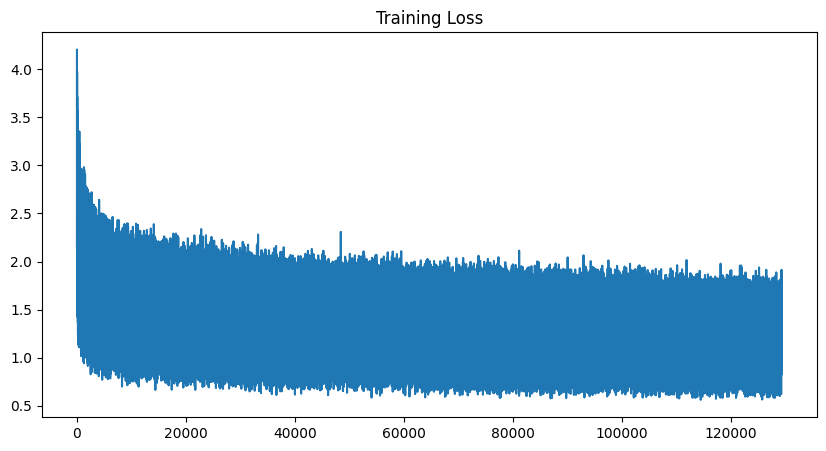

In [24]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger[100:])
_ = plt.title("Training Loss")

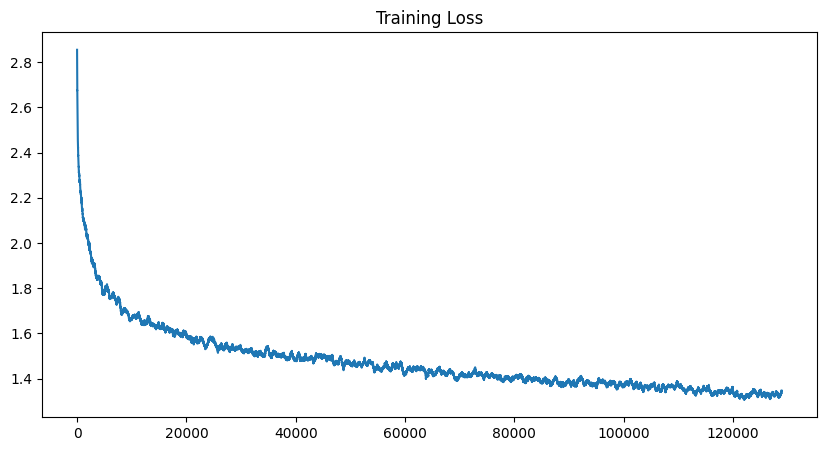

In [25]:
window_size = 512
data = np.convolve(np.array(training_loss_logger), np.ones(window_size)/window_size, mode="valid")
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(data)
_ = plt.title("Training Loss")

In [39]:
# Create a dataloader itterable object
dataiter = next(iter(data_loader_val))
# Sample from the itterable object
test_images, test_captions = dataiter

In [40]:
index = 0
test_image = test_images[index].unsqueeze(0)

A guy wearing a red wet shirt and black shorts while surfing. 


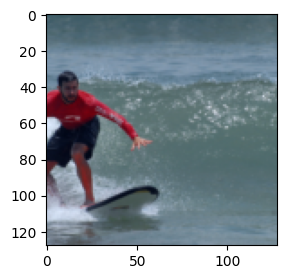

In [41]:
plt.figure(figsize = (3,3))
out = torchvision.utils.make_grid(test_image, 1, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))
print(test_captions[index])

In [56]:
# Add the Start-Of-Sentence token to the prompt to signal the network to start generating the caption
sos_token = 101 * torch.ones(1, 1).long()

# Set the temperature for sampling during generation
temp = 0.4

In [57]:
log_tokens = [sos_token]
caption_model.eval()

with torch.no_grad():
    # Encode the input image
    with torch.cuda.amp.autocast():
        # Forward pass
        image_embedding = caption_model.encoder(test_image.to(device))

    # Generate the answer tokens
    for i in range(50):
        input_tokens = torch.cat(log_tokens, 1)
        
        # Decode the input tokens into the next predicted tokens
        data_pred = caption_model.decoder(input_tokens.to(device), image_embedding)
        
        # Sample from the distribution of predicted probabilities
        dist = Categorical(logits=data_pred[:, -1] / temp)
        next_tokens = dist.sample().reshape(1, 1)
        
        # Append the next predicted token to the sequence
        log_tokens.append(next_tokens.cpu())
        
        # Break the loop if the End-Of-Caption token is predicted
        if next_tokens.item() == 102:
            break

In [58]:
# Convert the list of token indices to a tensor
pred_text = torch.cat(log_tokens, 1)

# Convert the token indices to their corresponding strings using the vocabulary
pred_text_strings = tokenizer.decode(pred_text[0], skip_special_tokens=True)

# Join the token strings to form the predicted text
pred_text = "".join(pred_text_strings)

# Print the predicted text
print(pred_text)

a man riding a surfboard on top of a wave.


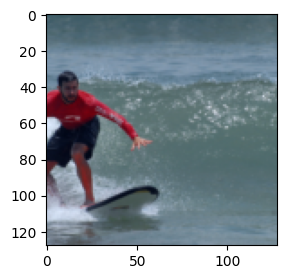

In [59]:
plt.figure(figsize = (3,3))
out = torchvision.utils.make_grid(test_image, 1, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))